Episode 10	Last reward: -2072.25	Average reward: -5432.57
Episode 20	Last reward: -2027.06	Average reward: -3924.70
Episode 30	Last reward: -1208.26	Average reward: -2915.47
Episode 40	Last reward: -5257.46	Average reward: -2743.58
Episode 50	Last reward: -2626.58	Average reward: -2341.25
Episode 60	Last reward: -1499.10	Average reward: -2133.71
Episode 70	Last reward: -1173.63	Average reward: -1848.14
Episode 80	Last reward: -1755.06	Average reward: -1653.95
Episode 90	Last reward: -1427.15	Average reward: -1623.03
Episode 100	Last reward: -1228.61	Average reward: -1683.50
Episode 110	Last reward: -1311.93	Average reward: -1625.26
Episode 120	Last reward: -997.52	Average reward: -1476.63
Episode 130	Last reward: -1723.63	Average reward: -1371.26
Episode 140	Last reward: -1118.85	Average reward: -1400.83
Episode 150	Last reward: -921.54	Average reward: -1307.05
Episode 160	Last reward: -1084.87	Average reward: -1245.21
Episode 170	Last reward: -1570.66	Average reward: -1213.51
Episode 

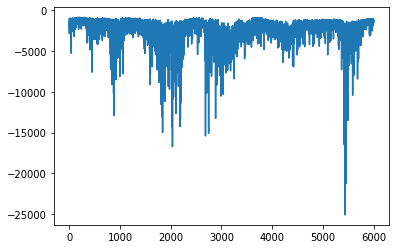

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  5 17:08:54 2020

@author: Admin
"""

# Quadcopter Env

import easydict
import gym
import numpy as np
from itertools import count
from collections import namedtuple
import logging
import logging.handlers


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt

from quad_env import QuadEnv

# Cart Pole
# based on:
# https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

# args = parser.parse_args()

args = easydict.EasyDict({
    "gamma": 0.99,
    "seed": 203,
    "render": False,
    "log_interval": 10,
    "write_logger":True
})

# env = gym.make('LunarLanderContinuous-v2')
env = QuadEnv()

# env.seed(args.seed)
torch.manual_seed(args.seed)

SavedAction = namedtuple('SavedAction', ['log_prob', 'value', 'next_state'])
# state_dim = env.observation_space.shape[0]
state_dim = 18
# action_dim = env.action_space.shape[0]
action_dim = 4

class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """

    def __init__(self, hidden_dim1=64, hidden_dim2=64, output_dim=64):
        super(Policy, self).__init__()
        self.affine_act = nn.Linear(state_dim, output_dim)
        # self.affine2_act = nn.Linear(hidden_dim1, output_dim)
        self.affine_policy = nn.Linear(state_dim, output_dim)
        self.act = nn.Tanh()
        # actor's layer
        self.action_mean = nn.Linear(output_dim, action_dim)
        self.action_var = nn.Linear(output_dim, action_dim)
        # critic's layer
        self.value_head = nn.Linear(output_dim, 1)
        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        # TODO map input to:
        # mean of action distribution,
        # variance of action distribution (pass this through a non-negative function),
        # state value

        # x = self.act1(self.affine1(x))
        # x = self.act1(self.affine2(x))
        # x = self.act1(self.affine3(x))
        # action_mean = self.action_mean(x)
        # action_var = F.softplus(self.action_var(x))
        y = self.act(self.affine_act(x))
        action_mean = self.act(self.action_mean(y))
        action_var = F.softplus(self.action_var(y))
        action_var = torch.add(action_var, 1e-10)
        y = self.act(self.affine_policy(x))
        state_values = self.value_head(y)  # <= Value Function not value of state
        if any(torch.isnan(x)) or any(torch.isnan(action_mean)) or any(torch.isnan(action_var)):
            print('NaN in forward pass')

        return 1000.0 * action_mean, 500.0 * action_var, state_values


model = Policy().float()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float()
    mu, sigma, state_value = model(state)
    # sigma += 10**-8

    # create a normal distribution over the continuous action space
    m = Normal(loc=mu, scale=sigma)

    # and sample an action using the distribution
    action = m.sample()

    next_state, reward, done, _ = env.step(action.data.numpy())

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value, next_state))

    # the action to take (left or right)
    return action.data.numpy(), next_state, reward, done


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []  # list to save actor (policy) loss
    value_losses = []  # list to save critic (value) loss
    returns = []  # list to save the true values

    # calculate the true value using rewards returned from the environment
    #for r in model.rewards[::-1]:
    for i in range(len(model.rewards)):
        # TODO compute the value at state x
        # via the reward and the discounted tail reward
        r = model.rewards[i]
        if i < len(model.rewards) - 1:
            value_next = saved_actions[i + 1][1].item()
        else:
            state = saved_actions[i][2]
            state = torch.from_numpy(state).float()
            _, _, state_value = model(state)
            value_next = state_value.item()
        R = args.gamma * value_next + r

        returns.insert(0, R)

    # whiten the returns
    returns = torch.tensor(returns).float()
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value, state), R in zip(saved_actions, returns):
        # TODO compute the advantage via subtracting off value
        advantage = R - value.item()

        # TODO calculate actor (policy) loss, from log_prob (saved in select action)
        # and from advantage
        policy_loss = -log_prob * advantage
        # append this to policy_losses
        policy_losses.append(policy_loss)
        # TODO calculate critic (value) loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
    # reset gradients

    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    # gradient clipping to solve exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


def main():
    if args.write_logger:
        log_filename = 'training_log.txt'
        train_logger = logging.getLogger('TrainLogger')
        train_logger.setLevel(logging.DEBUG)
        handler = logging.handlers.RotatingFileHandler(log_filename, maxBytes=10*1024*1024, backupCount=5)
        train_logger.addHandler(handler)

    running_reward = -8000

    # run infinitely many episodes, until performance criteria met
    episodic_rewards = []
    episodes = []

    for i_episode in count(1):
        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        for t in range(1, 300):
            # select action from policy
            action, state, reward, done = select_action(state)
            if any(np.isnan(action)):
                print('action is NaN')

            # take the action
            # state, reward, done, _ = env.step(action)

            if args.render and i_episode % 100 == 0:
                env.render()

            if args.write_logger:
                train_logger.debug('episode {0}, step {1}, state {2}, action {3}, reward {4}'.format(i_episode, t, state, action, reward))

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                episodes.append(i_episode)  # added
                episodic_rewards.append(ep_reward)
                break

        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # perform backprop
        finish_episode()

        # log results
        if i_episode % args.log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                i_episode, ep_reward, running_reward))

        # check if we have "solved" the problem
        # if running_reward > 200:
        if i_episode > 6000:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))

            # TODO plot episodic_rewards --- submit this plot with your code
            plt.figure()
            plt.plot(episodes, episodic_rewards)
            break


if __name__ == '__main__':
    main()

# New Section

We did many things
Nothing worked
What we learned: RL is BS
LAME
Just put a PID controller on your vehicles, and you'll be fine...

In [0]:
!unzip quad_sim.zip -d ./

Archive:  quad_sim.zip
   creating: ./quad_sim/
  inflating: ./quad_sim/ctrl.py      
  inflating: ./quad_sim/config.py    
  inflating: ./quad_sim/waypoints.py  
  inflating: ./quad_sim/trajectory.py  
   creating: ./quad_sim/utils/
   creating: ./quad_sim/__pycache__/
   creating: ./quad_sim/quadFiles/
  inflating: ./quad_sim/run_3D_simulation.py  
  inflating: ./quad_sim/utils/rotationConversion.py  
  inflating: ./quad_sim/utils/stateConversions.py  
  inflating: ./quad_sim/utils/__init__.py  
   creating: ./quad_sim/utils/__pycache__/
  inflating: ./quad_sim/utils/display.py  
  inflating: ./quad_sim/utils/quaternionFunctions.py  
  inflating: ./quad_sim/utils/animation.py  
  inflating: ./quad_sim/utils/windModel.py  
  inflating: ./quad_sim/utils/mixer.py  
  inflating: ./quad_sim/__pycache__/config.cpython-36.pyc  
  inflating: ./quad_sim/quadFiles/quad.py  
  inflating: ./quad_sim/quadFiles/__init__.py  
   creating: ./quad_sim/quadFiles/__pycache__/
  inflating: ./quad_sim/qu

In [0]:
!pip install gym
!pip install Box2D gym